## 1. Loading Required Packages

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# SMOTE
from imblearn.over_sampling import SMOTE

# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# SHAP
import shap
import tensorflow as tf
shap.initjs()

## 2. Load Data and Split

In [2]:
# Load CSV file
df = pd.read_csv('../Data/Fraud_Subset_10%.csv')

# Split features and label
X = df.drop('fraud', axis=1)
y = df['fraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

## 3. Apply SMOTE

In [3]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

C:\Users\ryan\anaconda3\envs\fraud_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## 4. Scale Data

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

## 5. Train Neural Network with KFold

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_index, val_index in kf.split(X_train_scaled, y_train_sm):
    X_t, X_v = X_train_scaled[train_index], X_train_scaled[val_index]
    y_t, y_v = y_train_sm.iloc[train_index], y_train_sm.iloc[val_index]

from tensorflow.keras import Input

model = Sequential([
    Input(shape=(X_t.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_t, y_t, epochs=30, batch_size=64, validation_data=(X_v, y_v), verbose=0)

preds = model.predict(X_v)
auc = roc_auc_score(y_v, preds)
auc_scores.append(auc)

print("Mean ROC AUC from 5-Fold CV:", np.mean(auc_scores))

415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
Mean ROC AUC from 5-Fold CV: 0.9981026585657817


## 6. Final Model & ROC Curve

467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


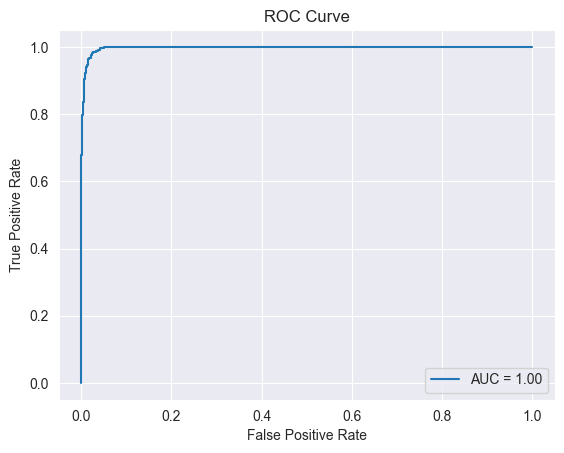

In [11]:
model.fit(X_train_scaled, y_train_sm, epochs=30, batch_size=64, verbose=0)

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_prob):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 7. Save Model

In [12]:
model.save('../Data/fraud_nn_model.h5')

## 8. SHAP Explainer

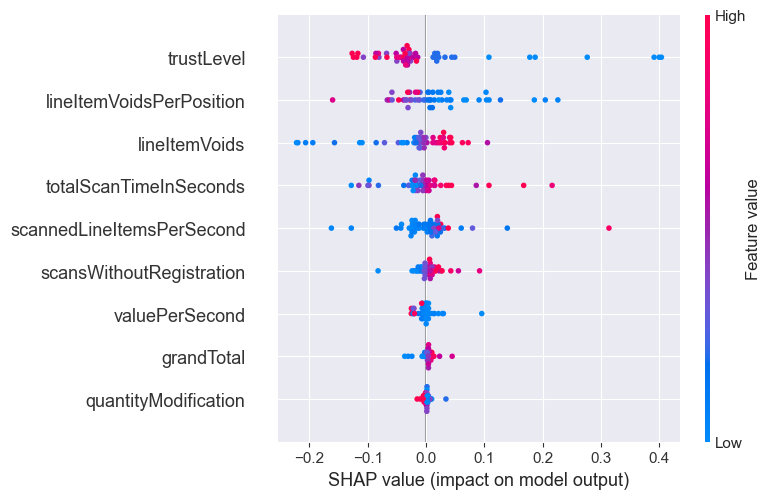

In [14]:
# Create DataFrames with the original column names
X_train_named = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_named = pd.DataFrame(X_test_scaled, columns=X.columns)

# SHAP explainer
explainer = shap.Explainer(model, X_train_named[:100])
shap_values = explainer(X_test_named[:50])

# Plot with real feature names
shap.summary_plot(shap_values, X_test_named[:50])
